# Gesture Recognition
In this group project, we are going to build a 3D Conv model and a 2D Conv RNN with GRU Model that will be able to predict the 5 gestures correctly.

In [66]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import imageio
import cv2
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [67]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, we will read the folder names for training and validation. We will also set the `batch_size` here. We will set the batch size in such a way that we are able to use the GPU in full capacity. We may keep increasing the batch size until the machine throws an error.

In [68]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 16

## Generator
This is common to both the Models. In the generator, we are preprocessing the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [69]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    #[folder[0] for folder in folder_list]
    #img_idx = [f for idx,f in  zip(range(len(files)), os.listdir('YOUR PICS DIRECTORY HERE')) if not idx%3]
    img_idx = [7,9,11,13,15,17,19,21,23,25]
    #num_batches = len(folder_list)//batch_size   # calculate the number of batches
    #print(len(folder_list))
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size   # calculate the number of batches
        #print('Number of Batches:',num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            # for now assuming size as 360*360 <dinesh,suman>
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #print(imgs[item])
                    #crop the images and resize them. Note that the images are of 2 different shape
                    image=cv2.resize(image, (120, 120))
                    (b, g, r)=cv2.split(image)
                    image=cv2.merge([r,g,b])
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (r - np.min(r)) / (np.max(r) - np.min(r)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (g - np.min(g)) / (np.max(g) - np.min(g)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (b - np.min(b)) / (np.max(b) - np.min(b)) #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size  !=0:
            # for now assuming size as 360*360 <dinesh,suman>
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape

                    image=cv2.resize(image, (120, 120))
                    (b, g, r)=cv2.split(image)
                    image=cv2.merge([r,g,b])
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (r - np.min(r)) / (np.max(r) - np.min(r)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (g - np.min(g)) / (np.max(g) - np.min(g)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (b - np.min(b)) / (np.max(b) - np.min(b)) #normalise and feed in the image in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [70]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =50  # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model 1 - Conv3D
#### With MaxPooling3D and TimeDistributed 

In [71]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2, l1

#write your model here
inputshape= (10,120,120,3)  
model1= Sequential()

model1.add(Conv3D(32, kernel_size=(4, 4, 4), input_shape=inputshape))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv3D(32, kernel_size=(4, 4, 4)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(4, 4, 4)))
model1.add(Dropout(0.4))

model1.add(Conv3D(64, kernel_size=(4, 4, 4),padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv3D(64, kernel_size=(4, 4, 4),padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(4, 4, 4),padding='same'))
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.4))

model1.add(Dense(256))
model1.add(Activation('relu'))

model1.add(Dropout(0.5))
model1.add(Dense(5))
model1.add(Activation('softmax'))

##### Optimizer - Model1

In [72]:
optimiser = optimizers.Adam()

#### Model 1 (Conv3D - Parameter Summary)

In [73]:
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 7, 117, 117, 32)   6176      
_________________________________________________________________
activation_34 (Activation)   (None, 7, 117, 117, 32)   0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 7, 117, 117, 32)   128       
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 4, 114, 114, 32)   65568     
_________________________________________________________________
activation_35 (Activation)   (None, 4, 114, 114, 32)   0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 114, 114, 32)   128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 1, 28, 28, 32)     0         
__________

###### Create the `train_generator` and the `val_generator` which will be used in `.fit_generator` 

In [74]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [75]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-CONV3D-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#We will reduce the LR if the Learning rate doesn't improve after 5 epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3) # write the REducelronplateau code here
print('learning_rate',LR)
callbacks_list = [checkpoint, LR]

learning_rate <keras.callbacks.ReduceLROnPlateau object at 0x7f29bdc895c0>


In [76]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Fitting Model 1 - Conv3D.
This will start training Model1 and with the help of the checkpoints, models will be saved at the end of each epoch.

In [77]:
history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 16
Source path =  ./Project_data/train ; batch size = 16
Epoch 1/50
42/42 [==============================] - 37s 875ms/step - loss: 2.3429 - categorical_accuracy: 0.2693 - val_loss: 1.9008 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-09-1403_39_12.025960/model-CONV3D-00001-2.34286-0.26935-1.90077-0.25000.h5
Epoch 2/50
42/42 [==============================] - 34s 799ms/step - loss: 1.5307 - categorical_accuracy: 0.3095 - val_loss: 1.3263 - val_categorical_accuracy: 0.4375

Epoch 00002: saving model to model_init_2020-09-1403_39_12.025960/model-CONV3D-00002-1.53069-0.30952-1.32635-0.43750.h5
Epoch 3/50
42/42 [==============================] - 34s 799ms/step - loss: 1.4482 - categorical_accuracy: 0.3542 - val_loss: 1.5787 - val_categorical_accuracy: 0.2857

Epoch 00003: saving model to model_init_2020-09-1403_39_12.025960/model-CONV3D-00003-1.44820-0.35417-1.57872-0.28571.h5
Epoch 4/50
42/42 [============

42/42 [==============================] - 33s 790ms/step - loss: 0.7159 - categorical_accuracy: 0.6994 - val_loss: 0.7186 - val_categorical_accuracy: 0.7054

Epoch 00029: saving model to model_init_2020-09-1403_39_12.025960/model-CONV3D-00029-0.71590-0.69940-0.71864-0.70536.h5
Epoch 30/50
42/42 [==============================] - 33s 790ms/step - loss: 0.7404 - categorical_accuracy: 0.7009 - val_loss: 0.6982 - val_categorical_accuracy: 0.6964

Epoch 00030: saving model to model_init_2020-09-1403_39_12.025960/model-CONV3D-00030-0.74042-0.70089-0.69822-0.69643.h5
Epoch 31/50
42/42 [==============================] - 33s 790ms/step - loss: 0.7405 - categorical_accuracy: 0.6994 - val_loss: 0.7302 - val_categorical_accuracy: 0.7143

Epoch 00031: saving model to model_init_2020-09-1403_39_12.025960/model-CONV3D-00031-0.74054-0.69940-0.73015-0.71429.h5
Epoch 32/50
42/42 [==============================] - 33s 790ms/step - loss: 0.7065 - categorical_accuracy: 0.7202 - val_loss: 0.6797 - val_catego

#### Plotting Test - Train Accuracy vs EPOCH and Test - Train Loss vs EPOCH for Model1 Conv3D

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


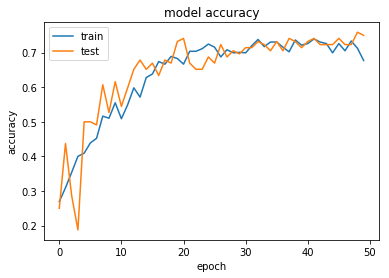

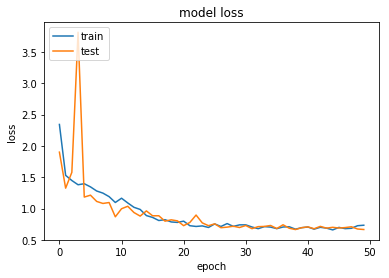

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 2 - RNN + GRU
#### With MaxPooling2D and TimeDistributed. Using Transfer Learning VGG16

In [79]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2, l1
from numpy import array
from keras.layers import LSTM,GRU
from keras.applications.vgg16 import VGG16


# create a VGG16 "model", we will use image with shape (120, 120, 3)
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(120, 120, 3)
)
# For All Non-Trainable Layers and using only Weights.

for layer in vgg.layers:
    layer.trainable = False
    
     
# create a Sequential model
model2 = Sequential()
# adding vgg model for 10 input images (keeping the right shape)
model2.add(TimeDistributed(vgg, input_shape=(10, 120, 120, 3)))


model2.add(TimeDistributed(Conv2D(64, kernel_size=(4, 4),padding='same')))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(TimeDistributed(Conv2D(64, kernel_size=(4, 4),padding='same')))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(TimeDistributed(MaxPooling2D(pool_size=(4, 4),padding='same')))
model2.add(Dropout(0.5))

model2.add(TimeDistributed(Conv2D(64, kernel_size=(4, 4),padding='same')))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(TimeDistributed(Conv2D(64, kernel_size=(4, 4),padding='same')))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(TimeDistributed(MaxPooling2D(pool_size=(4, 4),padding='same')))
model2.add(Dropout(0.5))


# now, flatten on each output to send 10 outputs with one dimension to LSTM
model2.add(TimeDistributed(Flatten()))
model2.add(GRU(128, activation='relu', return_sequences=False))
model2.add(Dropout(.5))
# finalize with standard Dense, Dropout...

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.5))
model2.add(Dense(5, activation='softmax')) # 5 classes for 5 different hand gestures


##### Optimizer - Model2

In [80]:
optimiser = optimizers.Adam(lr=0.005)

#### Model 2 (Conv2D RNN + GRU - Parameter Summary)

In [81]:
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, 10, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 3, 3, 64)      524352    
_________________________________________________________________
activation_41 (Activation)   (None, 10, 3, 3, 64)      0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 3, 3, 64)      256       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 3, 3, 64)      65600     
_________________________________________________________________
activation_42 (Activation)   (None, 10, 3, 3, 64)      0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 10, 3, 3, 64)      256       
__________

###### Create the `train_generator` and the `val_generator` which will be used in `.fit_generator` 

In [82]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [83]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-Conv2D-RNN-GRU-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#We will reduce the LR if the Learning rate doesn't improve after 5 epochs
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3) # write the REducelronplateau code here
print('learning_rate',LR)
callbacks_list = [checkpoint, LR]

learning_rate <keras.callbacks.ReduceLROnPlateau object at 0x7f29bbe98710>


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [84]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Fitting Model 2 - ConvD with RNN + GRU.
This will start training Model2 and with the help of the checkpoints, models will be saved at the end of each epoch.

In [ ]:
history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 16
Source path =  ./Project_data/train ; batch size = 16
Epoch 1/50
42/42 [==============================] - 27s 651ms/step - loss: 1.7043 - categorical_accuracy: 0.2336 - val_loss: 2.0248 - val_categorical_accuracy: 0.1607

Epoch 00001: saving model to model_init_2020-09-1403_39_12.025960/model-Conv2D-RNN-GRU-00001-1.70431-0.23363-2.02476-0.16071.h5
Epoch 2/50
42/42 [==============================] - 22s 530ms/step - loss: 1.4935 - categorical_accuracy: 0.3363 - val_loss: 1.3303 - val_categorical_accuracy: 0.3304

Epoch 00002: saving model to model_init_2020-09-1403_39_12.025960/model-Conv2D-RNN-GRU-00002-1.49345-0.33631-1.33028-0.33036.h5
Epoch 3/50
42/42 [==============================] - 22s 530ms/step - loss: 1.3535 - categorical_accuracy: 0.4122 - val_loss: 1.6601 - val_categorical_accuracy: 0.3661

Epoch 00003: saving model to model_init_2020-09-1403_39_12.025960/model-Conv2D-RNN-GRU-00003-1.35351-0.41220-1.66012-0.36607.h5
Epoch 

#### Plotting Test - Train Accuracy vs EPOCH and Test - Train Loss vs EPOCH for Model 2 Conv2D RNN+GRU

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
